In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
#from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC, LinearSVC
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import Perceptron
#from sklearn.linear_model import SGDClassifier
#from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv('test.csv')

In [3]:
train_test_df = train_df.append(test_df, sort=False)
PassengerId = test_df['PassengerId']

In [4]:
#train_test_df['Cabin_num'] = [len(x.split(' ')) for x in train_test_df.Cabin] #[train_test_df.Cabin.notnull()]]
#train_test_df.loc[train_test_df.Cabin.notnull(), 'Fare'] /= [len(x.split(' ')) for x in train_test_df.Cabin[train_test_df.Cabin.notnull()]]
train_test_df.loc[train_test_df.Fare.isnull(), 'Fare'] = train_test_df.Fare[train_test_df.Cabin.notnull()].mean()

In [5]:
#Name 处理为Title
train_test_df['title'] = pd.DataFrame(train_test_df.Name.str.extract('(?P<title>[A-Za-z]+)\.'))#, expand=False)

title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

title_dummies_df = pd.get_dummies(train_test_df.title.map(title_Dict), prefix='title_')
train_test_df = pd.concat([train_test_df, title_dummies_df], axis=1)

In [6]:
#Age
from sklearn.ensemble import RandomForestRegressor

### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):

    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df.filter(regex='Age|title_.*|Fare|Parch|SibSp|Pclass')
    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df[age_df.Age.notnull()]
    unknown_age = age_df[age_df.Age.isnull()]

    # y即目标年龄
    y = known_age.Age.values

    # X即特征属性值
    X = known_age.drop(columns='Age').values
    
    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)

    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age.drop(columns='Age').values)
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 

    return df, rfr

def set_missing_ages_by_mean(df):
    ptable = (df.pivot_table(index = 'title', aggfunc='mean')).Age.to_dict()
    df.loc[df.Age.isnull(),'Age'] = df[df.Age.isnull()].title.map(ptable)
    return df

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

def set_Cabin_type_new(df):
    #Cabin: 增加仓位号
    df.loc[df.Cabin.notnull(), 'Cabin'] = df[df.Cabin.notnull()].Cabin.apply(lambda x: x[0])
    df.loc[df.Cabin > 'G', 'Cabin'] = 'T'
    df.loc[df.Cabin.isnull(), 'Cabin'] = 'No'
    return df

train_test_df, rfr = set_missing_ages(train_test_df)
#train_test_df = set_missing_ages_by_mean(train_test_df)

#Age: bin & dummies
train_test_df['Age_bin'] = pd.cut(train_test_df['Age'], 6)
age_bin_dummies_df = pd.get_dummies(train_test_df['Age_bin'], prefix='Age_')
train_test_df = pd.concat([train_test_df, age_bin_dummies_df], axis=1).drop(columns='Age_bin')

#Cabin
train_test_df = set_Cabin_type(train_test_df)
#train_test_df = set_Cabin_type_new(train_test_df)

In [7]:
# add family size
train_test_df['family'] = train_test_df.Parch + train_test_df.SibSp + 1
train_test_df.loc[train_test_df.family >= 6, 'family'] = 6
dummies_family = pd.get_dummies(train_test_df['family'], prefix='family')

#Embarked :修改为是否最后一站上船
#泰坦尼克号从英国的南安普顿港（S）出发，途径法国瑟堡（C）和爱尔兰昆士敦（Q），那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。
#train_test_df['LastEmbarked'] = (train_test_df.Embarked == 'Q') + 0

#Pclass, Sex, Embarked  : dummies
dummies_Pclass = pd.get_dummies(train_test_df['Pclass'], prefix='Pclass')
dummies_Sex = pd.get_dummies(train_test_df['Sex'], prefix= 'Sex')
dummies_Embarked = pd.get_dummies(train_test_df['Embarked'], prefix= 'Embarked')
dummies_Cabin = pd.get_dummies(train_test_df['Cabin'], prefix='Cabin')

train_test_df = pd.concat([train_test_df, dummies_Pclass, dummies_Sex, dummies_Embarked, dummies_Cabin, dummies_family], axis=1)
#train_test_df = pd.concat([train_test_df, dummies_Pclass, dummies_Sex, dummies_Cabin, dummies_family], axis=1)

train_test_df.drop(columns=['Pclass', 'Sex', 'Embarked', 'Cabin', 'title', 'family'], inplace=True)

# add child
train_test_df['child'] = (train_test_df.Age < 12) + 0

# add mother
train_test_df['mother'] = ((train_test_df.title__Mrs==1 + (train_test_df.Parch > 1)) > 0 ) + 0



In [8]:
#scale
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()

train_test_df['Fare'] = scaler.fit_transform(train_test_df[['Fare']], scaler.fit(train_test_df[['Fare']]))

In [9]:
train_test_df.drop(columns=['Name','Age','Ticket','PassengerId'], inplace=True)
#train_test_df.info()

In [10]:
train_df_clean = train_test_df.iloc[0:891,:]
test_df_clean = train_test_df.iloc[891::,:]

In [29]:
from sklearn import linear_model

clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=1e-6)
X = train_df_clean.drop(columns='Survived').values
y = train_df_clean.Survived.values
clf.fit(X,y)
predictions = clf.predict(test_df_clean.drop(columns='Survived'))

result = pd.DataFrame({'PassengerId':PassengerId.values, 'Survived':predictions.astype(np.int32)})
#result.to_csv("./my_predictions.csv", index=False)

In [30]:
from sklearn.ensemble import BaggingRegressor

# fit到BaggingRegressor之中
clf = linear_model.LogisticRegression(C=1, penalty='l1', tol=1e-6)
bagging_clf = BaggingRegressor(clf, n_estimators=20, max_samples=0.8, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=-1)
bagging_clf.fit(X, y)

predictions = bagging_clf.predict(test_df_clean.drop(columns='Survived'))
result2 = pd.DataFrame({'PassengerId':PassengerId.values, 'Survived':predictions.astype(np.int32)})
#result2.to_csv("./my_bagging_predictions2.csv", index=False)

In [31]:
ans = pd.read_csv('./0836.csv')
ans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB


In [32]:
print("norm:", (ans.Survived == result.Survived).sum())
print("bag:", (ans.Survived == result2.Survived).sum())


norm: 368
bag: 388


In [41]:
train_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 28 columns):
Survived                 891 non-null float64
SibSp                    891 non-null int64
Parch                    891 non-null int64
Fare                     891 non-null float64
title__Master            891 non-null uint8
title__Miss              891 non-null uint8
title__Mr                891 non-null uint8
title__Mrs               891 non-null uint8
title__Officer           891 non-null uint8
title__Royalty           891 non-null uint8
Age__(0.0902, 16.136]    891 non-null uint8
Age__(16.136, 32.102]    891 non-null uint8
Age__(32.102, 48.068]    891 non-null uint8
Age__(48.068, 64.034]    891 non-null uint8
Age__(64.034, 80.0]      891 non-null uint8
family                   891 non-null float64
Pclass_1                 891 non-null uint8
Pclass_2                 891 non-null uint8
Pclass_3                 891 non-null uint8
Sex_female               891 non-null uint8
Sex_male 

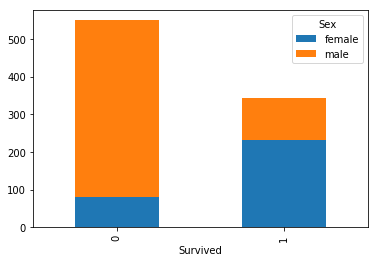

In [16]:
pd.crosstab(train_df.Survived, train_df.Sex).plot.bar(stacked=True)

In [17]:
a = train_df.copy()
a.loc[a.Cabin.notnull(), 'Cabin'] = a[a.Cabin.notnull()].Cabin.apply(lambda x: x[0])
#a.loc[a[a.Cabin.notnull()].Cabin > 'G', 'Cabin'] = 'T'
a.loc[a.Cabin > 'G', 'Cabin'] = 'T'

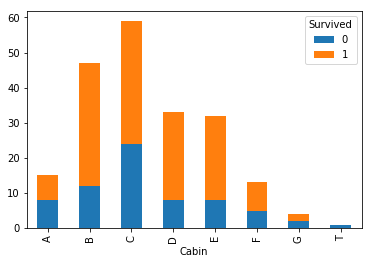

In [18]:
pd.crosstab(a.Cabin, a.Survived,).plot.bar(stacked=True)

In [19]:
test_df[test_df.Cabin.notnull()].Cabin.apply(lambda x: x[0]).value_counts()

C    35
B    18
D    13
E     9
F     8
A     7
G     1
Name: Cabin, dtype: int64